# Hottown -- The Tourist Logger

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['pdf.fonttype'] = 42
import requests
import io
from datetime import datetime
from dateutil.parser import parse

In [81]:
# Import the data that was collected by the Arduino and sent to my webserver.
url="http://borniert.com/tourilogger/tourilog.csv"
raw_data = requests.get(url).content

In [82]:
# Move the data to a dataframe. Clean it up. 
df_data = pd.read_csv(io.StringIO(raw_data.decode('utf-8')), delimiter=';', header=None, names=['time', 'temp', 'hum', 'noise'])
df_data['time'] = df_data['time'].replace({'_': ' '}, regex=True)
df_data['time'] = pd.to_datetime(df_data['time'])
df_data.index = df_data['time']
del df_data['time']
df_data.head()

,temp,hum,noise
time,,,
2016-08-23 16:59:29,22.99,42.74,1.29
2016-08-23 16:59:59,22.99,42.67,0.64
2016-08-23 17:00:29,22.99,42.63,0.64
2016-08-23 17:00:59,22.99,42.72,1.29
2016-08-23 17:01:29,NaN,NaN,2.26


In [54]:
# Check a GPX file in order to figure out how to access all the points.
import gpxpy
gpx = gpxpy.parse(open('./data/tourilog4.gpx'))

print("{} track(s)".format(len(gpx.tracks)))
track = gpx.tracks[0]

print("{} segment(s)".format(len(track.segments)))
segment = track.segments[0]

print("{} point(s)".format(len(segment.points)))

1 track(s)
4 segment(s)
5 point(s)


In [83]:
# Export the GPS data to a dataframe.
import os
gpxes = os.listdir("data")
data = []

for gpx in gpxes:
    for segment in track.segments:
        for point in segment.points:
            data.append([point.longitude, point.latitude,
                     point.elevation, point.time])
columns = ['long', 'lat', 'alt', 'time']
df_gps = pd.DataFrame(data, columns=columns)

df_gps['time'] = pd.to_datetime(df_gps['time'])
df_gps.index = df_gps['time']
del df_gps['time']

df_gps.head()

,long,lat,alt
time,,,
2016-08-23 17:23:28,-73.963184,40.807375,36.0
2016-08-23 17:23:48,-73.963240,40.807379,36.0
2016-08-23 17:24:45,-73.963241,40.807380,36.0
2016-08-23 17:29:52,-73.963099,40.807397,36.0
2016-08-23 17:30:10,-73.963242,40.807379,36.0


In [84]:
# Merge the two dataframes. 
df = pd.merge(df_data, df_gps, right_index=True, left_index=True, how="outer")
df.tail()

,temp,hum,noise,long,lat,alt
time,,,,,,
2016-08-24 07:51:46,28.39,53.43,0.64,NaN,NaN,NaN
2016-08-24 07:52:16,28.51,53.34,0.32,NaN,NaN,NaN
2016-08-24 07:52:46,28.60,53.13,0.64,NaN,NaN,NaN
2016-08-24 07:53:16,28.70,54.59,0.64,NaN,NaN,NaN
2016-08-24 07:53:46,28.81,53.11,1.93,NaN,NaN,NaN


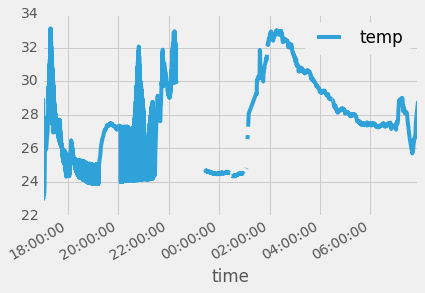

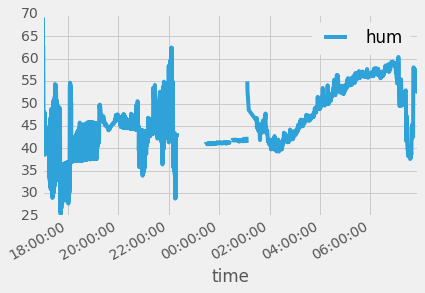

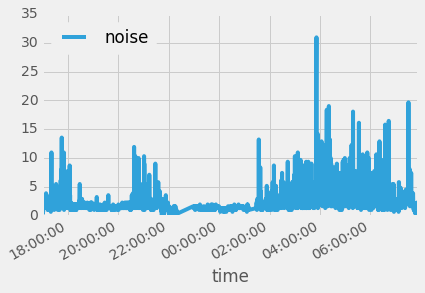

In [85]:
# Let's plot all data. 
df_data.plot(y='temp')
df_data.plot(y='hum')
df_data.plot(y='noise')

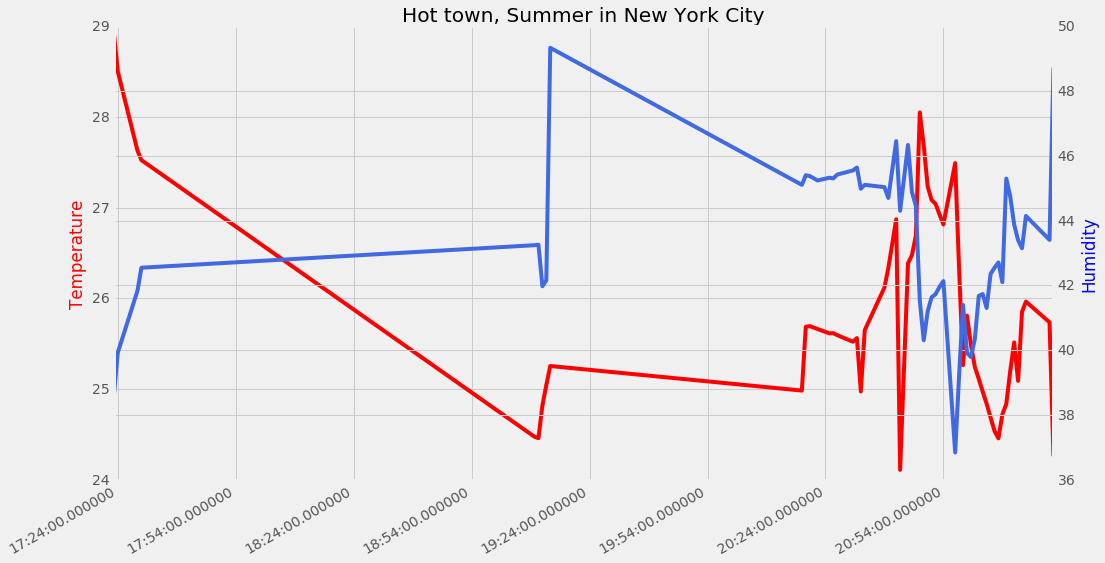

In [86]:
# Let's plot just a part of the data and simplify it.

fig, ax1 = plt.subplots(figsize=(15,9), sharex=True)
df['2016-08-23'].resample('T').mean().dropna().plot(y='temp', color='red', legend=False, ax=ax1)
ax1.set_ylabel('Temperature', color='red')
ax1.set_xlabel('')
ax1.set_title('Hot town, Summer in New York City')

ax2 = ax1.twinx()
df['2016-08-23'].resample('T').mean().dropna().plot(y='hum', color='royalblue', legend=False, ax=ax2)
ax2.set_ylabel('Humidity', color='blue')

plt.savefig('tourilog.pdf', tranparent=True)

In [88]:
# How many points with complete data do we have? 
len(df.resample('2T').mean().dropna())

36

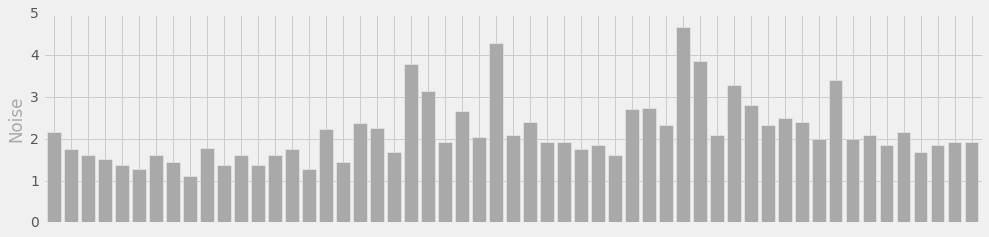

In [89]:
fig, ax = plt.subplots(figsize=(15,3.5))
df['2016-08-23'].resample('T').mean().dropna().plot(y='noise', color='darkgrey', kind='bar', width=0.8, legend=False, ax=ax)
ax.set_ylabel('Noise', color='darkgrey')
ax.set_xlabel('')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.savefig('tourilog_noise.pdf', tranparent=True)

In [90]:
# I am going to map the data. To avoid having a bunch of markers at the same position, 
# I am trying to drop point that are too close together using the following function. 
from geopy import distance as geopy_distance

def calc_dist(lat1,long1,lat2,long2):
    return geopy_distance.distance((lat1,long1), (lat2,long2)).kilometers

## Generating Maps

In [91]:
# Where are the hottest spots?
df_hot = df.resample('T').mean().dropna()
df_hot = df_hot.sort_values(by='temp', ascending=False)
df_hot.head()

,temp,hum,noise,long,lat,alt
time,,,,,,
2016-08-23 17:23:00,28.9300,38.5875,2.1750,-73.963212,40.807377,36.0
2016-08-23 17:24:00,28.5025,39.9275,1.7725,-73.963241,40.807380,36.0
2016-08-23 20:48:00,28.0500,41.5275,2.0925,-73.976481,40.788624,24.0
2016-08-23 20:49:00,27.6850,40.3075,2.4175,-73.976192,40.788849,24.0
2016-08-23 17:29:00,27.6300,41.8350,1.6100,-73.963099,40.807397,36.0


In [92]:
# Get rid of point that are too close. 

min_dist = 2.5
df_hot['distance'] = None

for i in range(0, len(df_hot.index) - 1):
    former_lat = df_hot.iloc[i, df_hot.columns.get_loc('lat')]
    former_long = df_hot.iloc[i, df_hot.columns.get_loc('long')]
    next_lat = df_hot.iloc[i + 1, df_hot.columns.get_loc('lat')]
    next_long = df_hot.iloc[i + 1, df_hot.columns.get_loc('long')]
    
    df_hot.iloc[i, df_hot.columns.get_loc('distance')] = calc_dist(former_lat, former_long, next_lat, next_long)


df_hotspots = df_hot[df_hot['distance'] > min_dist]
len(df_hotspots)

11

In [93]:
# Calculate the center of the map according to the markers. 
lats = list()
longs = list()
for point in data:
    lats.append(point[1])
    longs.append(point[0])
midilat = sum(lats) / len(lats)
midilong = sum(longs) / len(longs)

In [97]:
import folium
map_example = folium.Map(location=[midilat,midilong], zoom_start=14, tiles='Stamen Terrain')
for i in range(0, len(df_hotspots.index)):
    description = 'Temperature:' + str(df_hotspots['temp'][i]) + '| Humidity:' + str(df_hotspots['hum'][i]) + '| Noise:' + str(df_hotspots['noise'][i])
    # iframe = folium.element.IFrame(html=html, width=200, height=200)
    # popup = folium.Popup(iframe, max_width=200)
    folium.Marker([df_hotspots['lat'][i],df_hotspots['long'][i]], popup=description).add_to(map_example)
map_example.save('output/hottown.html')

In [98]:
# Where are the coldest spots?
df_cold = df.resample('T').mean().dropna()
df_cold = df_cold.sort_values(by='temp', ascending=True)

# Get rid of point that are too close. 
df_cold['distance'] = None
for i in range(0, len(df_cold.index) - 1):
    former_lat = df_cold.iloc[i, df_cold.columns.get_loc('lat')]
    former_long = df_cold.iloc[i, df_cold.columns.get_loc('long')]
    next_lat = df_cold.iloc[i + 1, df_cold.columns.get_loc('lat')]
    next_long = df_cold.iloc[i + 1, df_cold.columns.get_loc('long')]
    
    df_cold.iloc[i, df_cold.columns.get_loc('distance')] = calc_dist(former_lat, former_long, next_lat, next_long)
df_cold = df_cold[df_cold['distance'] > min_dist]

# Generate the map
map_example = folium.Map(location=[midilat,midilong], zoom_start=14, tiles='Stamen Terrain')
for i in range(0, len(df_cold.index)):
    description = 'Temperature: ' + str(df_cold['temp'][i]) + '| Humidity: ' + str(df_cold['hum'][i]) + '| Noise: ' + str(df_cold['noise'][i])
    folium.Marker([df_cold['lat'][i],df_cold['long'][i]], popup=description).add_to(map_example)
map_example.save('output/coldtown.html')

In [95]:
# Where are the wettest spots?
df_wet = df.resample('T').mean().dropna()
df_wet = df_wet.sort_values(by='hum', ascending=False)
df_wet.head()

# Get rid of point that are too close. 
df_wet['distance'] = None
for i in range(0, len(df_wet.index) - 1):
    former_lat = df_wet.iloc[i, df_wet.columns.get_loc('lat')]
    former_long = df_wet.iloc[i, df_wet.columns.get_loc('long')]
    next_lat = df_wet.iloc[i + 1, df_wet.columns.get_loc('lat')]
    next_long = df_wet.iloc[i + 1, df_wet.columns.get_loc('long')]
    
    df_wet.iloc[i, df_wet.columns.get_loc('distance')] = calc_dist(former_lat, former_long, next_lat, next_long)
df_wet = df_wet[df_wet['distance'] > min_dist]

# Generate the map
map_example = folium.Map(location=[midilat,midilong], zoom_start=14, tiles='Stamen Terrain')
for i in range(0, len(df_wet.index)):
    description = 'Temperature: ' + str(df_wet['temp'][i]) + '| Humidity: ' + str(df_wet['hum'][i]) + '| Noise: ' + str(df_wet['noise'][i])
    folium.Marker([df_wet['lat'][i],df_wet['long'][i]], popup=description).add_to(map_example)
map_example.save('output/wettown.html')

In [96]:
# Where are the noisyest spots?
df_noisy = df.resample('T').mean().dropna()
df_noisy = df_noisy.sort_values(by='noise', ascending=False)

# Get rid of point that are too close. 
df_noisy['distance'] = None
for i in range(0, len(df_noisy.index) - 1):
    former_lat = df_noisy.iloc[i, df_noisy.columns.get_loc('lat')]
    former_long = df_noisy.iloc[i, df_noisy.columns.get_loc('long')]
    next_lat = df_noisy.iloc[i + 1, df_noisy.columns.get_loc('lat')]
    next_long = df_noisy.iloc[i + 1, df_noisy.columns.get_loc('long')]
    
    df_noisy.iloc[i, df_noisy.columns.get_loc('distance')] = calc_dist(former_lat, former_long, next_lat, next_long)
df_noisy = df_noisy[df_noisy['distance'] > min_dist]

# Generate the map
map_example = folium.Map(location=[midilat,midilong], zoom_start=14, tiles='Stamen Terrain')
for i in range(0, len(df_noisy.index)):
    description = 'Temperature:' + str(df_noisy['temp'][i]) + '| Humidity:' + str(df_noisy['hum'][i]) + '| Noise:' + str(df_noisy['noise'][i])
    folium.Marker([df_noisy['lat'][i],df_noisy['long'][i]], popup=description).add_to(map_example)
map_example.save('output/noisytown.html')